In [370]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison
from utils.plot import two_action_prob_plot

from algorithm import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer
from policy import UniformPolicyModel,PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [371]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [372]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [373]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [374]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [375]:
pref_dataset

[Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [376]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

In [377]:
positive_actions

tensor([0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2,
        2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0])

In [378]:
negative_actions

tensor([1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1,
        1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1])

In [379]:
# check transition
check_cyclic_order(p_list,actions)

(True, ('-10', '0', '10'))

In [380]:
check_data_consistency(pref_dataset)

0.8

## Nash equilibrium

In [381]:
# compute nash equilibrium
import nashpy as nash
import numpy as np

# A = np.array([
#     [0.5, 0.1, 0.8],
#     [0.9, 0.5, 0.1],
#     [0.2, 0.9, 0.5]
# ])


game = nash.Game(p_list, -p_list)

equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  
    


Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [382]:
nash_point= [eq[0][0],eq[0][1]]
nash_point

[0.5185960617933865, 0.09025694564670378]

## RLHF

In [383]:
learned_reward_model = RewardModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [384]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [385]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-20 10:48:44,698 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 0 loss: 0.6915 acc: 0.52
2024-11-20 10:48:44,705 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 2 loss: 0.6910 acc: 0.52
2024-11-20 10:48:44,711 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 4 loss: 0.6905 acc: 0.52
2024-11-20 10:48:44,716 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 6 loss: 0.6902 acc: 0.52
2024-11-20 10:48:44,722 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 8 loss: 0.6898 acc: 0.55
2024-11-20 10:48:44,727 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 10 loss: 0.6896 acc: 0.55
2024-11-20 10:48:44,733 - /home/hanwen/policy_optimization/exp/algorithm.py[line:127] - INFO: [Reward] Epoch 12 loss: 0.6894 acc: 0.55
2024-11-20 10:48:44,738 - /home/hanwen/policy_optimization/e

In [386]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [387]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)
ref_policy(torch.tensor([[0.0]]))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')

In [388]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 

In [389]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 10:48:44,794 - /home/hanwen/policy_optimization/exp/algorithm.py[line:196] - INFO: [Policy] Epoch 0 loss: -0.1960 reward: 0.1960 ref_reward: 0.1991 improvement: -1.59%
2024-11-20 10:48:44,804 - /home/hanwen/policy_optimization/exp/algorithm.py[line:196] - INFO: [Policy] Epoch 2 loss: -0.2023 reward: 0.2023 ref_reward: 0.1991 improvement: 1.61%
2024-11-20 10:48:44,816 - /home/hanwen/policy_optimization/exp/algorithm.py[line:196] - INFO: [Policy] Epoch 4 loss: -0.2084 reward: 0.2084 ref_reward: 0.1991 improvement: 4.63%
2024-11-20 10:48:44,835 - /home/hanwen/policy_optimization/exp/algorithm.py[line:196] - INFO: [Policy] Epoch 6 loss: -0.2143 reward: 0.2143 ref_reward: 0.1991 improvement: 7.61%
2024-11-20 10:48:44,846 - /home/hanwen/policy_optimization/exp/algorithm.py[line:196] - INFO: [Policy] Epoch 8 loss: -0.2203 reward: 0.2203 ref_reward: 0.1991 improvement: 10.61%
2024-11-20 10:48:44,856 - /home/hanwen/policy_optimization/exp/algorithm.py[line:196] - INFO: [Policy] Epoch

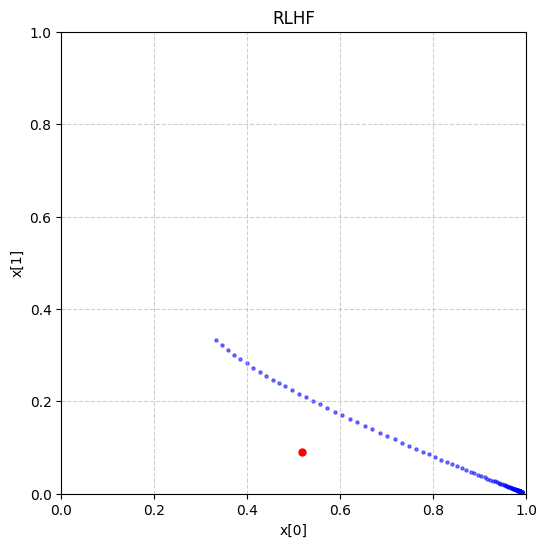

In [390]:
policy_optimizer.optimize(states=states, num_epochs=100)

In [391]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [392]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.991
P(action=0) = 0.004
P(action=10) = 0.006

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


In [393]:
# compare the learned policy with the reference policy
score = model_comparison(policy, ref_policy,feature_func)
print(f"\nRLHF model and base model comparison score: {score:.3f}")


RLHF model and base model comparison score: 0.083


## DPO

In [394]:
policy2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [395]:
dpo_optimizer = DirectPreferenceOptimizer(
    policy=policy2,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 10:48:45,786 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 0 loss: 0.6940 grad norm: 0.0502 


2024-11-20 10:48:45,803 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 5 loss: 0.6902 grad norm: 0.0228 
2024-11-20 10:48:45,843 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 10 loss: 0.6890 grad norm: 0.0079 
2024-11-20 10:48:45,886 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 15 loss: 0.6889 grad norm: 0.0042 
2024-11-20 10:48:45,928 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 20 loss: 0.6890 grad norm: 0.0094 
2024-11-20 10:48:45,971 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 25 loss: 0.6890 grad norm: 0.0072 
2024-11-20 10:48:46,013 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 30 loss: 0.6889 grad norm: 0.0041 
2024-11-20 10:48:46,056 - /home/hanwen/policy_optimization/exp/algorithm.py[line:318] - INFO: [Policy] Epoch: 35 loss: 0.6888 grad 

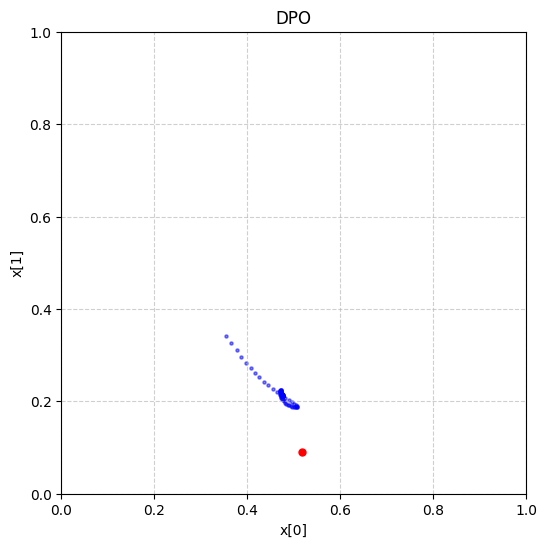

In [396]:
dpo_optimizer.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
)

In [397]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy2(test_state)
    print("\nLearned policy probabilities:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")


Learned policy probabilities:
P(action=-10) = 0.475
P(action=0) = 0.214
P(action=10) = 0.310


In [398]:
# compare the learned policy with the reference policy
score = model_comparison(policy2, ref_policy,feature_func)
print(f"\nDPO model and base model comparison score: {score:.3f}")


DPO model and base model comparison score: 0.037


## SPPO

In [399]:
policy3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [400]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [401]:
sppo_optimizer = SelfPlayPreferenceOptimizer(
    policy=policy3,
    ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

2024-11-20 10:48:47,175 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 0 loss: 0.0028 grad norm: 0.0540 
2024-11-20 10:48:47,361 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 5 loss: 0.0000 grad norm: 0.0038 
2024-11-20 10:48:47,402 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 10 loss: 0.0003 grad norm: 0.0117 
2024-11-20 10:48:47,451 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 15 loss: 0.0000 grad norm: 0.0014 
2024-11-20 10:48:47,500 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 20 loss: 0.0001 grad norm: 0.0073 
2024-11-20 10:48:47,553 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 25 loss: 0.0000 grad norm: 0.0013 
2024-11-20 10:48:47,606 - /home/hanwen/policy_optimization/exp/algorithm.py[line:436] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad n

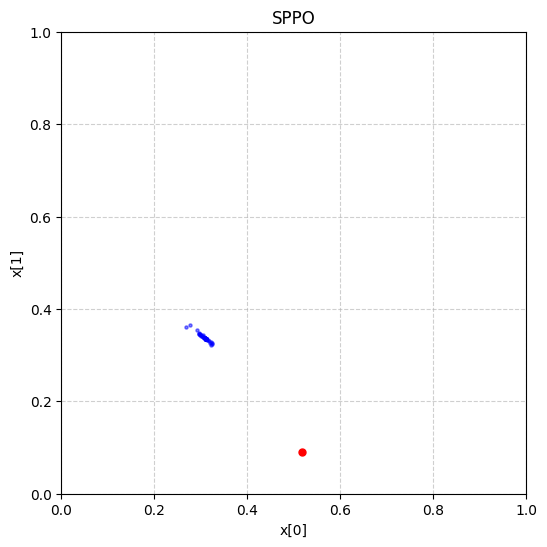

In [402]:
sppo_optimizer.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=100
)

In [403]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy3(test_state)
    print("\nLearned policy probabilities:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")


Learned policy probabilities:
P(action=-10) = 0.311
P(action=0) = 0.335
P(action=10) = 0.354


In [404]:
# compare the learned policy with the reference policy
score = model_comparison(policy3, ref_policy,feature_func)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


SPPO model and base model comparison score: -0.046


## SPPO Closed-form solution

In [405]:
class SPPOClosedForm:
   def __init__(
       self,
       policy: nn.Module,
       ref_policy: nn.Module,
       eta: float = 1e-4,
       batch_size: int = 64,
       logger: Logger = None,
   ):
       self.policy = policy
       self.ref_policy = ref_policy
       self.eta = eta
       self.batch_size = batch_size
       self.logger = logger

   def compute_pi(
       self,
       states: torch.tensor,
       positive_actions: torch.tensor,
       p_list:List[List[float]],
   ):
    
       with torch.no_grad():
            new_distributions = []
            for i in range(0, len(states)):
               state = states[i]
               ref_distribution = self.ref_policy(state).squeeze(0)
                
               p_yi_pi = torch.zeros_like(ref_distribution)
               
               pref_action = positive_actions[i]
               p_pref = ref_distribution[positive_actions[i]]
               

               p_y_yi = []
               for j in range(len(actions) - 1):
                   if j != positive_actions[i]:
                        p_y_yi.append(p_list[pref_action][j] * ref_distribution[j])
                
               p_y_yi.append(p_pref * 0.5)     
               p_y_yi = sum(p_y_yi)
               
               exp_term = torch.exp(self.eta * p_yi_pi)
                    
               Z = torch.sum(ref_distribution * exp_term, dim=-1, keepdim=True)
               new_distribution = ref_distribution * exp_term / Z
               new_distributions.append(new_distribution) 
               
               
            new_distributions = torch.stack(new_distributions)  
            
               
            
       return new_distributions
   
   def optimize(
       self,
       states: torch.tensor,
       positive_actions: torch.tensor,
       p_list:List[List[float]],
       num_iters: int = 3,
   ):
       
        for iter in range(num_iters):
           
           new_distributions = self.compute_pi(states, positive_actions, p_list)

           ref_distributions = self.ref_policy(states)
           print(iter)
           print(new_distributions)
          
        #    if self.logger:
        #         self.logger.info(
        #             f"[Policy] Iteration {iter} "
        #             f"mean policy prob: {new_distributions.mean().item():.4f} "
        #             f"mean ref prob: {ref_distributions.mean().item():.4f}"
        #         )

          
           self.ref_policy = copy.deepcopy(self.policy)

        return new_distributions

In [406]:
policy4 = PolicyModel(
    state_dim=1,
    actions=actions,
    hidden_dim=128,
    device=device
).to(device)

In [407]:
sppo = SPPOClosedForm(
    policy=policy,
    ref_policy=ref_policy,
    eta=1e-3,
    batch_size=64,
    logger=logger
)

In [408]:
sppo_closed_form = sppo.optimize(
    states=states,
    positive_actions=positive_actions,
    p_list=p_list,
    num_iters=3
)   

0
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3

In [409]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")

    action_probs2 = policy2(test_state)
    print("\nLearned policy probabilities(DPO):")
    for action, prob in zip(actions, action_probs2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    action_probs3 = policy3(test_state)
    print("\nLearned policy probabilities(SPPO):")
    for action, prob in zip(actions, action_probs3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs4 = policy4(test_state)
    print("\nLearned policy probabilities(SPPO-ClosedForm):")
    for action, prob in zip(actions, action_probs4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        


Learned policy probabilities(RLHF):
P(action=-10) = 0.991
P(action=0) = 0.004
P(action=10) = 0.006

Learned policy probabilities(DPO):
P(action=-10) = 0.475
P(action=0) = 0.214
P(action=10) = 0.310

Learned policy probabilities(SPPO):
P(action=-10) = 0.311
P(action=0) = 0.335
P(action=10) = 0.354

Learned policy probabilities(SPPO-ClosedForm):
P(action=-10) = 0.328
P(action=0) = 0.318
P(action=10) = 0.354


## Plot

In [410]:
rlhf_accuracy = compare_pref_with_policy(policy, pref_dataset)
print(f"RLHF accuracy: {rlhf_accuracy:.2f}")

DPO_accuracy = compare_pref_with_policy(policy2, pref_dataset)
print(f"DPO accuracy: {DPO_accuracy:.2f}")

SPPO_accuracy = compare_pref_with_policy(policy3, pref_dataset)
print(f"SPPO accuracy: {SPPO_accuracy:.2f}")

SPPO_closed_form_accuracy = compare_pref_with_policy(policy4, pref_dataset)
print(f"SPPO closed form accuracy: {SPPO_closed_form_accuracy:.2f}")

NameError: name 'compare_pref_with_policy' is not defined

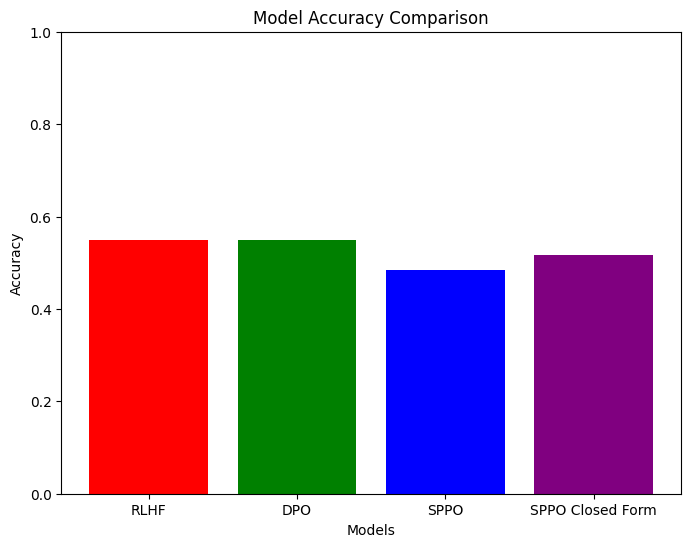

In [ ]:
plot_model_accuracies(
    model_names=["RLHF", "DPO", "SPPO", "SPPO Closed Form"],
    accuracies=[rlhf_accuracy, DPO_accuracy, SPPO_accuracy, SPPO_closed_form_accuracy],
    filename="model_accuracies.png"
)

In [ ]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [ ]:
# compute nash equilibrium
import nashpy as nash
import numpy as np

# A = np.array([
#     [0.5, 0.1, 0.8],
#     [0.9, 0.5, 0.1],
#     [0.2, 0.9, 0.5]
# ])


game = nash.Game(p_list, -p_list)

equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]
